# Extendable and invertible manifold learning with geometry regularized autoencoders (GRAE)

The current version of this notebook aims to reproduce results for Autoencoders, GRAE and UMAP over 1 run only for demonstration purposes. All results can be
reproduced over more runs by changing the "Fit models/Experiment parameters" subsection. Ideally, a GPU should be selected to run experiments (Runtime->Change runtime type->Hardware Accelerator->GPU in Google Colab).

See the Topological Autoencoders subsection to learn how to set up this notebook
to benchmark them. Otherwise, they are not available by default.

We computed the Diffusion Nets embeddings using their source code, which is not reproduced here.

## Dependencies, seeds and utilities

In [43]:
# Install unavailable dependencies
# %%capture
#
# !pip install phate
# !pip install scikit-bio

In [44]:
# Check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Aug 05 00:31:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 206... WDDM  | 00000000:08:00.0  On |                  N/A |
| 31%   33C    P8     9W / 184W |   2021MiB /  8192MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [45]:
# Imports
import os
import shutil
import copy
from six.moves import cPickle as pickle #for performance

import warnings  # Ignore sklearn future warning
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import torch
import math
import scipy
import torch.nn.functional as F
import torch.nn as nn
from sklearn.manifold import TSNE
from sklearn.decomposition import FastICA, PCA
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr, spearmanr

import time

from sklearn.model_selection import train_test_split
from skbio.stats.distance import mantel

# Datasets import
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.datasets as torch_datasets
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import pdist, squareform
from scipy import ndimage
from scipy.stats import pearsonr


import urllib
from scipy.io import loadmat

# Model imports
import umap
import phate

# Plots
import matplotlib.pyplot as plt

plt

## Experiment parameters

In [46]:
# Experiment
# Experiment parameters
RUNS = 1
FIT_RATIO = .8
DATASETS = ['Faces', 'RotatedDigits']
MODELS = ['AE', 'GRAE_10',  'GRAE_50', 'GRAE_100']

# Model parameters
BATCH = 200
LR = .0001
WEIGHT_DECAY = 1
EPOCHS = 200

# Dataset parameters
FIT_DEFAULT = .8  # Ratio of data to use for training
SAMPLE = 10000  # Number of points to sample from synthetic manifolds

# Seeds and base path for data
BASEPATH = 'data'
SEED = 7512183 # Used for data generation and splits

# 20 Random states for different training runs. Add more if you need more runs
RANDOM_STATES = [36087, 63286, 52270, 10387, 40556, 52487, 26512, 28571, 33380,
                9369, 28478,  4624, 29114, 41915,  6467,  4216, 16025, 34823,
                29854, 23853]

# Set seed for both torch and numpy
np.random.seed(SEED)
torch.manual_seed(SEED)

# Create directory for data
if not os.path.exists(BASEPATH):
  os.mkdir(BASEPATH)

# Create directory for results
if not os.path.exists('results'):
  os.mkdir('results')

In [47]:
# Utils
# Results Logger
class Book():
  def __init__(self, datasets, models, metrics):
    self.col = ['model', 'dataset', 'run', 'split'] + metrics
    self.log = list()
    self.models = models
    self.datasets = datasets
    self.splits = ('train', 'test')
    self.metrics = metrics

  def add_entry(self, model, dataset, run, split, **kwargs):
    # Proof read entry
    self.check(model, dataset, split)
    self.check_metrics(kwargs)

    metrics_ordered = [kwargs[k] for k in self.metrics]

    signature = [model, dataset, run, split]
    entry = signature +  metrics_ordered

    if len(entry) != len(self.col):
      raise Exception('Entry size is wrong.')

    self.log.append(entry)

  def check(self, model, dataset, split):
    if model not in self.models:
      raise Exception('Invalid model name.')

    if dataset not in self.datasets:
      raise Exception('Invalid dataset name.')

    if split not in self.splits:
      raise Exception('Invalid split name.')

  def check_metrics(self, kwargs):
    if len(kwargs.keys()) != len(self.metrics):
      raise Exception('Wrong number of metrics.')

    for key in kwargs.keys():
      if key not in self.metrics:
        raise Exception(f'Trying to add undeclared metric {key}')


  def get_df(self):
    return pd.DataFrame.from_records(self.log, columns=self.col)


def refine_df(df, df_metrics):
  df_group = df.groupby(['split', 'dataset', 'model'])
  mean = df_group.mean().drop(columns=['run']).round(4)

  # Add rank columns
  for m in df_metrics:
    # Higher is better
    ascending = False

    if m == 'reconstruction' or m.split('_')[0] == 'mrre':
      # Lower is better
      ascending = True

    loc = mean.columns.get_loc(m) + 1
    rank = mean.groupby(['split', 'dataset'])[m].rank(method='min', ascending=ascending)
    mean.insert(loc=loc, column=f'{m}_rank', value = rank)

  return mean


def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di

def slice_3D(X, Y, idx, axis, p=1):
  axis = X[:, axis]

  sli = np.zeros(shape=X.shape[0])
  sli[idx] = 1

  sampler = np.random.choice(a=[False, True], size=(sli.shape[0],), p=[1-p, p])

  sli = np.logical_and(sli, sampler)

  rest = np.logical_not(sli)

  X_2, Y_2 = X[rest], Y[rest]
  X_3, Y_3 = X[sli], Y[sli]


  return X_2, Y_2, X_3, Y_3

def make_holes(x, y, n=12, eps_range=(.2, .5), seed=SEED):
  np.random.seed(SEED)

  hole_idx = np.random.choice(x.shape[0], size=n, replace=False)
  d = squareform(pdist(x))
  eps_list = np.random.uniform(eps_range[0], eps_range[1], n)

  test_idx = list()

  for i, idx in enumerate(hole_idx):
    d_line, eps = d[idx], eps_list[i]
    test_idx.append(np.argwhere(d_line < eps))

  test_idx = np.unique(np.concatenate(test_idx))
  train_idx = np.full(fill_value=True, shape=x.shape[0])
  train_idx[test_idx] = False

  return x[train_idx], y[train_idx], x[test_idx], y[test_idx]


def plot_3D(x, y, z, c):
  fig, (a1)  = plt.subplots(1,1, figsize=(10, 10))
  a1 = fig.add_subplot(111, projection='3d')
  a1.scatter(x, y, z, c=c, cmap='jet', s = 2)
  a1.view_init(elev=10, azim = 90)

  plt.show()

def plot_3D_grey(x_train, y_train, z_train, x_test, y_test, z_test, c):
  fig, (a1)  = plt.subplots(1,1, figsize=(10, 10))
  a1 = fig.add_subplot(111, projection='3d')
  a1.scatter(x_train, y_train, z_train, color='grey', s = 2, alpha=.5)
  a1.scatter(x_test, y_test, z_test, c=c, cmap='jet', s = 2)
  a1.view_init(elev=10, azim = 90)

  plt.show()

## Datasets

In [48]:
# Datasets
# Base class
class BaseDataset(Dataset):
  """Simple class for X and Y ndarrays."""
  def __init__(self, x, y, split, split_ratio, seed):
    if split not in ('train', 'test', 'none'):
        raise Exception('split argument should be "train", "test" or "none"')

    x, y = self.get_split(x, y, split, split_ratio, seed)

    self.data = x.float()
    self.targets = y.float()

  def __getitem__(self, index):
    return self.data[index], self.targets[index]

  def __len__(self):
    return len(self.data)

  def numpy(self, idx=None):
    if idx == None:
      return self.data.numpy(), self.targets.numpy()
    else:
      return self.data.numpy()[idx], self.targets.numpy()[idx]

  def get_split(self, x, y, split, split_ratio, seed):
      if split == 'none':
        return torch.from_numpy(x), torch.from_numpy(y)

      n = x.shape[0]
      train_idx, test_idx = train_test_split(np.arange(n),
                                            train_size=split_ratio,
                                            random_state=seed)

      if split == 'train':
        return torch.from_numpy(x[train_idx]), torch.from_numpy(y[train_idx])
      else:
        return torch.from_numpy(x[test_idx]), torch.from_numpy(y[test_idx])



class NumpyDataset(Dataset):
  """Wrapper for x ndarray with no targets."""
  def __init__(self, x):
    self.data = torch.from_numpy(x).float()

  def __getitem__(self, index):
    return self.data[index]

  def __len__(self):
    return len(self.data)

  def numpy(self, idx=None):
    if idx == None:
      return self.data.numpy()
    else:
      return self.data.numpy()[idx]


class SwissRoll(BaseDataset):
    """Standard Swiss Roll class."""
    def __init__(self, n_samples=SAMPLE, split='none', split_ratio=FIT_DEFAULT,
                 seed=SEED, factor=6, sli_points=250):
      x, y = datasets.make_swiss_roll(n_samples=n_samples, random_state=seed)

      # Backup first axis, as it represents one of the underlying latent
      # variable we aim to recover
      self.y_pure = copy.deepcopy(x[:, 1])

      # Normalize
      x = scipy.stats.zscore(x)

      # Get absolute distance from origin
      ab = np.abs(x[:, 1])
      sort = np.argsort(ab)

      # Take the sli_points points closest to origin
      # This is not used by the base class, but will be used by the Ribbons
      # children class to remove a thin slice from the roll
      self.test_idx = sort[0:sli_points]


      # Apply rotation  to achieve same variance on all axes
      x[:, 1] *= factor

      theta = math.pi/4
      phi = math.pi/3.3
      rho = 0

      cos = math.cos(theta)
      sin = math.sin(theta)

      cos_phi = math.cos(phi)
      sin_phi = math.sin(phi)

      cos_rho = math.cos(rho)
      sin_rho = math.sin(rho)

      rot = np.array([[cos, 0, sin],[0, 1, 0],[-sin, 0, cos]])

      rot_2 = np.array([[cos_phi, -sin_phi, 0],[sin_phi, cos_phi, 0],[0, 0, 1]])
      rot_3 = np.array([[1, 0, 0],[0, cos_rho, -sin_rho],[0, sin_rho, cos_rho]])


      x = x  @ rot_2 @ rot_3 @ rot
      x = scipy.stats.zscore(x) # Normalize for true unit variance

      super().__init__(x, y, split, split_ratio, seed)

    def get_source(self):
      # First source is coloring (representing the 'rolled' axis), second is
      # the 'untransformed' first axis (length of the roll)
      return self.targets.numpy(), self.y_pure


class Ribbons(SwissRoll):
    """Swiss Roll class where the test split is a thin 'ribbon' of sli_points
    points removed from the middle of the manifold."""
    def __init__(self, n_samples=SAMPLE, sli_points=250, split='none',
                 split_ratio=FIT_DEFAULT, seed=SEED):

      super().__init__(n_samples, split, split_ratio=split_ratio, seed=seed,
                       factor=6, sli_points=sli_points)

    def get_split(self, x, y, split, split_ratio, seed):
      if split == 'none':
        return torch.from_numpy(x), torch.from_numpy(y)

      x_train, y_train, x_test, y_test = slice_3D(x, y, self.test_idx, 1)
      train_mask = np.full(x.shape[0], fill_value=True)
      train_mask[self.test_idx] = False
      test_mask = np.logical_not(train_mask)


      if split == 'train':
        self.y_pure = self.y_pure[train_mask]
        return torch.from_numpy(x_train), torch.from_numpy(y_train)
      else:
        self.y_pure = self.y_pure[test_mask]
        return torch.from_numpy(x_test), torch.from_numpy(y_test)

    def get_source(self):
      # First source is coloring, second is the axis 1 (length of the roll)
      return self.targets.numpy(), self.y_pure


class Rotated(BaseDataset):
    def __init__(self, fetcher, split='none', split_ratio=FIT_DEFAULT,
                 seed=SEED, n_images=3, n_rotations=360, max_degree=360):
      """Pick n_images of n different classes and return a dataset with
         n_rotations for each image."""
      self.max_degree = max_degree

      np.random.seed(seed)

      transforms_MNIST = transforms.Compose([
        transforms.ToTensor(),
      ])

      train = fetcher(root=BASEPATH, train=True, download=True,
                      transform=transforms_MNIST)

      X = train.data.detach().numpy().reshape(60000,784)
      X = X/X.max()
      Y = train.targets.detach().numpy()

      # Pick classes
      classes = np.random.choice(10, size=n_images, replace=False)

      imgs = list()

      for i in classes:
        subset = X[Y == i]
        i = np.random.choice(subset.shape[0], size=1)
        imgs.append(subset[i])


      def generate_rotations(img, c, N):
        img = img.reshape((28,28))

        new_angles = np.linspace(0, self.max_degree, num=N, endpoint=False)

        img_new = np.zeros((N,28,28))

        for i, ang in enumerate(new_angles):
          img_new[i,:,:] = ndimage.rotate(img, ang, reshape=False)


          X1 = img_new.reshape(len(new_angles), 784)

        return X1, np.full(shape=(N,), fill_value=c)


      rotations = [generate_rotations(img, c=i, N=n_rotations)
        for i, img in enumerate(imgs)]

      X_rotated, Y_rotated = zip(*rotations)

      X_rotated  = np.concatenate(X_rotated)
      Y_rotated  = np.concatenate(Y_rotated)


      super().__init__(X_rotated, Y_rotated, split, split_ratio, seed)


class RotatedDigits(Rotated):
  """3 rotated MNIST digits with 360 rotations per image, for a total of
  1080 samples."""
  def __init__(self, split='none', split_ratio=FIT_DEFAULT, seed=SEED,
               n_images=3, n_rotations=360):
    super().__init__(torch_datasets.MNIST, split, split_ratio, seed,
                     n_images, n_rotations)



class Faces(BaseDataset):
    def __init__(self, split='none', split_ratio=FIT_DEFAULT, seed=SEED):

      self.url = 'http://stt3795.guywolf.org/Devoirs/D02/face_data.mat'
      self.root = os.path.join(BASEPATH, 'faces')

      if not os.path.exists(self.root):
        os.mkdir(self.root)
        self._download()

      d = loadmat(os.path.join(self.root, 'face_data.mat'))

      x = d['images'].T

      y = d['poses'].T

      super().__init__(x, y, split, split_ratio, seed)


      # Save y_1 and y_2 for coloring
      self.y_2 = self.targets[:, 1].numpy()
      self.y_1 = self.targets[:, 0].numpy()

      # Keep only one latent in the targets attribute for compatibility with
      # other datasets
      self.targets = self.targets[:, 0]

    def _download(self):
      print('Downloading Faces dataset')
      urllib.request.urlretrieve(self.url, os.path.join(self.root, 'face_data.mat'))

    def get_source(self):
      return self.y_1, self.y_2


# Dict to call dataset constructors using a string
dataset_constructors = dict(
    ribbons=Ribbons,
    Faces=Faces,
    RotatedDigits=RotatedDigits)

## Models

### AE Definition

In [49]:
# Vanilla AE
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)



# AE building blocks
class Encoder_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, z_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim1)
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.mu = nn.Linear(hidden_dim3, z_dim)
    def forward(self, x):
        hidden1 = F.relu(self.linear(x))
        hidden2 = F.relu(self.linear2(hidden1))
        hidden3 = F.relu(self.linear3(hidden2))
        z_mu = self.mu(hidden3)
        return z_mu

class Decoder_MLP(nn.Module):
    def __init__(self, z_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim, sigmoid_act = False):
        super().__init__()
        self.linear = nn.Linear(z_dim, hidden_dim1)
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.out = nn.Linear(hidden_dim3, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid_act = sigmoid_act
    def forward(self, x):
        hidden1 = F.relu(self.linear(x))
        hidden2 = F.relu(self.linear2(hidden1))
        hidden3 = F.relu(self.linear3(hidden2))
        if self.sigmoid_act == False:
            predicted = (self.out(hidden3))
        else:
            predicted = F.sigmoid(self.out(hidden3))
        return predicted

class AE_MLP(nn.Module):
    def __init__(self, enc, dec):
        super().__init__()
        self.enc = enc
        self.dec = dec

    def forward(self, x):
        latent = self.enc(x)
        predicted = self.dec(latent)
        return predicted, latent


# AE main class
class AE():
    """Autoencoder class with sklearn interface."""
    def __init__(self, input_size, random_state=SEED, track_rec=False,
                 AE_wrapper=AE_MLP, batch_size=BATCH, lr=LR,
                 weight_decay=WEIGHT_DECAY, reduction='sum', epochs=EPOCHS, **kwargs):
      layer_1 = 800
      layer_2 = 400
      layer_3 = 200
      self.lr = lr
      self.epochs = epochs
      self.batch_size = batch_size
      self.weight_decay = weight_decay
      self.encoder = Encoder_MLP(input_size, layer_1, layer_2, layer_3, 2)
      self.decoder = Decoder_MLP(2, layer_3, layer_2, layer_1, input_size)
      self.model = AE_wrapper(self.encoder, self.decoder, **kwargs)
      self.model = self.model.float().to(device)

      self.criterion = nn.MSELoss(reduction=reduction)

      self.optimizer = torch.optim.Adam(self.model.parameters(),
                                        lr = self.lr,
                                        weight_decay=self.weight_decay)
      self.loss = list()
      self.track_rec = track_rec
      self.random_state = random_state

    def fit(self, x):
      # Train AE
      self.model.train()

      # Reproducibility
      torch.manual_seed(self.random_state)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False



      loader = torch.utils.data.DataLoader(x, batch_size=self.batch_size,
                                           shuffle=True)

      for epoch in range(self.epochs):
        for batch in loader:
            data, y = batch
            data = data.to(device)

            self.optimizer.zero_grad()
            x_hat, _ = self.model(data)
            x_hat = x_hat.to(device)
            loss = self.criterion(data, x_hat)
            loss.backward()
            self.optimizer.step()

        if self.track_rec:
          x_np, _ = x.numpy()
          x_hat = self.inverse_transform(self.transform(x))
          self.loss.append(mean_squared_error(x_np, x_hat))

    def transform(self, x):
      self.model.eval()
      loader = torch.utils.data.DataLoader(x, batch_size=self.batch_size,
                                           shuffle=False)
      z = [self.encoder(batch.to(device)).cpu().detach().numpy()
      for batch, _ in loader]

      return np.concatenate(z)

    def fit_transform(self, x):
      self.fit(x)
      return self.transform(x)

    def inverse_transform(self, z):
      self.model.eval()
      z = NumpyDataset(z)
      loader = torch.utils.data.DataLoader(z, batch_size=self.batch_size,
                                           shuffle=False)
      x_hat = [self.decoder(batch.to(device)).cpu().detach().numpy()
      for batch in loader]

      return np.concatenate(x_hat)


class ManifoldLoss(nn.Module):
    def __init__(self, lam):
      super().__init__()
      self.lam = lam
      self.MSE = nn.MSELoss(reduction='sum')
      self.loss = None

    def forward(self, x, y, z, emb):
      self.loss = self.MSE(x, y) + self.lam * self.MSE(z, emb)
      return self.loss

    def backward(self):
      self.loss.backward()

    def decay_lam(self, factor):
      self.lam *= factor



### GRAE Definitions

In [50]:

class ManifoldNet(AE):
  """Base class for GRAE."""
  def __init__(self, input_size, embedder, random_state, track_rec=False, lam=10, lam_decay=1, **kwargs):
      super().__init__(input_size, random_state, track_rec)
      self.criterion = ManifoldLoss(lam)
      self.emb = None
      self.targets = None
      self.precomputed = False
      self.embedder_args = kwargs
      self.embedder = embedder
      self.lam_decay = lam_decay

  def fit(self, x):
    self.model.train()

    # Reproducibility
    torch.manual_seed(self.random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    x_np, self.targets = x.numpy()

    # Compute embedding target
    if not self.precomputed:
      embedder_m = self.embedder(**self.embedder_args,
                                 random_state=self.random_state)

      emb = embedder_m.fit_transform(x_np)

      # Normalize
      emb = scipy.stats.zscore(emb)

      self.emb = emb


    # Loader to iterate over both data batches and target embedding batches
    data = ConcatDataset(torch.from_numpy(self.emb).float(), x)

    loader = torch.utils.data.DataLoader(data,
                                          batch_size=self.batch_size,
                                          shuffle=True)

    for epoch in range(self.epochs):
      for embedding, batch in loader:
          x_in, _ = batch[0].to(device), batch[1]
          embedding = embedding.to(device)
          self.optimizer.zero_grad()
          x_hat, z_mu = self.model(x_in)

          x_hat = x_hat.to(device)
          z_mu = z_mu.to(device)
          self.criterion(x_in, x_hat, z_mu, embedding)
          self.criterion.backward()
          self.optimizer.step()

      self.criterion.decay_lam(self.lam_decay)

      if self.track_rec:
        x_hat = self.inverse_transform(self.transform(x))
        self.loss.append(mean_squared_error(x_np, x_hat))

  def plot_latent(self):
    plt.scatter(*self.emb.T, c=self.targets, cmap="jet")
    plt.show()

  def set_embedding(self, emb):
    self.emb = emb
    self.precomputed = True



# Variants of GRAE
class GRAE(ManifoldNet):
  """Vanilla GRAE."""
  def __init__(self, input_size, random_state=SEED, track_rec=False,
               lam=10, lam_decay=1, t='auto', knn=20, n_landmark=2000,
               mds='metric'):
    super().__init__(input_size=input_size,
                      random_state=random_state,
                      embedder=phate.PHATE,
                      track_rec=track_rec,
                      lam=lam,
                      lam_decay=lam_decay,
                      t=t,
                      knn=knn,
                      n_jobs=-1,
                      verbose=0,
                      n_landmark=n_landmark,
                      mds=mds)


class GRAE_UMAP(ManifoldNet):
  """UMAP GRAE, as presented in the supplement."""
  def __init__(self, input_size, random_state=SEED,
               track_rec=False, lam=10, lam_decay=1, n_neighbors=15):
    super().__init__(input_size=input_size,
                      random_state=random_state,
                      embedder=umap.UMAP,
                      track_rec=track_rec,
                      lam=lam,
                      n_neighbors=n_neighbors)


class GRAE_TSNE(ManifoldNet):
  """t-SNE GRAE, as presented in the supplement."""
  def __init__(self, input_size, random_state=SEED, track_rec=False,
               lam=10, lam_decay=1, perplexity=30):
    super().__init__(input_size=input_size,
                      random_state=random_state,
                      embedder=TSNE,
                      track_rec=track_rec,
                      lam=lam,
                      n_jobs=-1,
                      verbose=0,
                      perplexity=perplexity)


### Topological Autoencoders
If reproduction of the TopoAE results is needed, the original code of the authors (https://osf.io/abuce/?view_only=f16d65d3f73e4918ad07cdd08a1a0d4b)
should be downloaded and saved under the folder topologically-constrained-autoencoder
on Google Drive and the cells in this section should be uncommented.


In [51]:
# # Mount Drive
# from google.colab import drive
# drive.mount('/content/drive')

# sys.path.append('/content/drive/My Drive/topologically-constrained-autoencoder')
# !pip install pipenv

# !cd '/content/drive/My Drive/topologically-constrained-autoencoder'
# !pipenv install

# import src.models

In [52]:
# # TopoAE Wrapper

# class TopoBaseAE(nn.Module):
#   # Using TopoRegEdgeSymmetric from their results
#   def __init__(self, enc, dec, lam):
#       super().__init__()
#       self.encoder = enc
#       self.decoder = dec
#       self.topo_sig = src.models.approx_based.TopologicalSignatureDistance(match_edges='symmetric')
#       self.reconstruction = nn.MSELoss(reduction='sum')
#       self.lam = lam
#       self.latent_norm = torch.nn.Parameter(data=torch.ones(1),
#                                               requires_grad=True)

#   @staticmethod
#   def _compute_distance_matrix(x, p=2):
#       x_flat = x.view(x.size(0), -1)
#       distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)
#       return distances

#   def forward(self, x):
#       """Compute the loss of the Topologically regularized autoencoder.

#       Args:
#           x: Input data

#       Returns:
#           Tuple of final_loss, (...loss components...)

#       """
#       latent = self.encoder(x)
#       x_rec = self.decoder(latent)

#       x_distances = self._compute_distance_matrix(x)

#       dimensions = x.size()
#       if len(dimensions) == 4:
#           # If we have an image dataset, normalize using theoretical maximum
#           batch_size, ch, b, w = dimensions
#           # Compute the maximum distance we could get in the data space (this
#           # is only valid for images wich are normalized between -1 and 1)
#           max_distance = (2**2 * ch * b * w) ** 0.5
#           x_distances = x_distances / max_distance
#       else:
#           # Else just take the max distance we got in the batch
#           x_distances = x_distances / x_distances.max()

#       latent_distances = self._compute_distance_matrix(latent)
#       latent_distances = latent_distances / self.latent_norm

#       # Use reconstruction loss of autoencoder
#       ae_loss = self.reconstruction(x, x_rec)



#       topo_error, topo_error_components = self.topo_sig(
#           x_distances, latent_distances)

#       # normalize topo_error according to batch_size
#       batch_size = dimensions[0]
#       topo_error = topo_error / float(batch_size)
#       loss = ae_loss + self.lam * topo_error

#       return loss


# class TopoAE(AE):
#   def __init__(self, lam, input_size, random_state=SEED, track_rec=False, batch_size=BATCH, lr=LR, weight_decay=WEIGHT_DECAY):
#     super().__init__(input_size=input_size,
#                    random_state=random_state,
#                    track_rec=track_rec,
#                    AE_wrapper=TopoBaseAE,
#                    batch_size = batch_size,
#                    lr = lr,
#                    lam=lam,
#                    weight_decay=WEIGHT_DECAY)

#   def fit(self, x):
#     # Train AE
#     self.model.train()

#     # Reproducibility
#     torch.manual_seed(self.random_state)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

#     x_np, _ = x.numpy()

#     loader = torch.utils.data.DataLoader(x,batch_size=self.batch_size,
#                                           shuffle=True)

#     for epoch in range(self.epochs):
#       for batch in loader:
#           data, y = batch
#           data = data.to(device)

#           # TopoAE handles loss internally
#           loss = self.model(data)

#           self.optimizer.zero_grad()
#           loss.backward()
#           self.optimizer.step()

#       if self.track_rec:
#         x_hat = self.inverse_transform(self.transform(x))
#         self.loss.append(mean_squared_error(x_np, x_hat))

## Metrics

### Unsupervised metrics (Table 1)

In [53]:
# Unsupervised Metrics
# Code adapted from the Topological autoencoders paper
class MeasureCalculator():
    # measures = MeasureRegistrator()

    def __init__(self, X, Z, X_hat, k_max=20):
        self.k_max = k_max
        self.X = X
        self.X_hat = X_hat
        self.pairwise_X = squareform(pdist(X))
        self.pairwise_Z = squareform(pdist(Z))
        self.neighbours_X, self.ranks_X = \
            self._neighbours_and_ranks(self.pairwise_X, k_max)
        self.neighbours_Z, self.ranks_Z = \
            self._neighbours_and_ranks(self.pairwise_Z, k_max)


    @staticmethod
    def _neighbours_and_ranks(distances, k):
        """
        Inputs:
        - distances,        distance matrix [n times n],
        - k,                number of nearest neighbours to consider
        Returns:
        - neighbourhood,    contains the sample indices (from 0 to n-1) of kth nearest neighbor of current sample [n times k]
        - ranks,            contains the rank of each sample to each sample [n times n], whereas entry (i,j) gives the rank that sample j has to i (the how many 'closest' neighbour j is to i)
        """
        # Warning: this is only the ordering of neighbours that we need to
        # extract neighbourhoods below. The ranking comes later!
        indices = np.argsort(distances, axis=-1, kind='stable')

        # Extract neighbourhoods.
        neighbourhood = indices[:, 1:k+1]

        # Convert this into ranks (finally)
        ranks = indices.argsort(axis=-1, kind='stable')

        return neighbourhood, ranks

    def get_X_neighbours_and_ranks(self, k):
        return self.neighbours_X[:, :k], self.ranks_X

    def get_Z_neighbours_and_ranks(self, k):
        return self.neighbours_Z[:, :k], self.ranks_Z

    def compute_k_independent_measures(self):
        return {key: fn(self) for key, fn in
                self.measures.get_k_independent_measures().items()}

    def compute_k_dependent_measures(self, k):
        return {key: fn(self, k) for key, fn in
                self.measures.get_k_dependent_measures().items()}

    def compute_measures_for_ks(self, ks):
        return {
            key: np.array([fn(self, k) for k in ks])
            for key, fn in self.measures.get_k_dependent_measures().items()
        }


    # @measures.register(False)
    def stress(self):
        sum_of_squared_differences = \
            np.square(self.pairwise_X - self.pairwise_Z).sum()
        sum_of_squares = np.square(self.pairwise_Z).sum()

        return np.sqrt(sum_of_squared_differences / sum_of_squares)

    # @measures.register(False)
    def rmse(self):
        n = self.pairwise_X.shape[0]
        sum_of_squared_differences = np.square(
            self.pairwise_X - self.pairwise_Z).sum()
        return np.sqrt(sum_of_squared_differences / n**2)

    @staticmethod
    def _trustworthiness(X_neighbourhood, X_ranks, Z_neighbourhood,
                         Z_ranks, n, k):
        '''
        Calculates the trustworthiness measure between the data space `X`
        and the latent space `Z`, given a neighbourhood parameter `k` for
        defining the extent of neighbourhoods.
        '''

        result = 0.0

        # Calculate number of neighbours that are in the $k$-neighbourhood
        # of the latent space but not in the $k$-neighbourhood of the data
        # space.
        for row in range(X_ranks.shape[0]):
            missing_neighbours = np.setdiff1d(
                Z_neighbourhood[row],
                X_neighbourhood[row]
            )

            for neighbour in missing_neighbours:
                result += (X_ranks[row, neighbour] - k)

        return 1 - 2 / (n * k * (2 * n - 3 * k - 1) ) * result

    # @measures.register(True)
    def trustworthiness(self, k):
        X_neighbourhood, X_ranks = self.get_X_neighbours_and_ranks(k)
        Z_neighbourhood, Z_ranks = self.get_Z_neighbours_and_ranks(k)
        n = self.pairwise_X.shape[0]
        return self._trustworthiness(X_neighbourhood, X_ranks, Z_neighbourhood,
                                     Z_ranks, n, k)

    # @measures.register(True)
    def continuity(self, k):
        '''
        Calculates the continuity measure between the data space `X` and the
        latent space `Z`, given a neighbourhood parameter `k` for setting up
        the extent of neighbourhoods.

        This is just the 'flipped' variant of the 'trustworthiness' measure.
        '''

        X_neighbourhood, X_ranks = self.get_X_neighbours_and_ranks(k)
        Z_neighbourhood, Z_ranks = self.get_Z_neighbours_and_ranks(k)
        n = self.pairwise_X.shape[0]
        # Notice that the parameters have to be flipped here.
        return self._trustworthiness(Z_neighbourhood, Z_ranks, X_neighbourhood,
                                     X_ranks, n, k)

    # @measures.register(True)
    def neighbourhood_loss(self, k):
        '''
        Calculates the neighbourhood loss quality measure between the data
        space `X` and the latent space `Z` for some neighbourhood size $k$
        that has to be pre-defined.
        '''

        X_neighbourhood, _ = self.get_X_neighbours_and_ranks(k)
        Z_neighbourhood, _ = self.get_Z_neighbours_and_ranks(k)

        result = 0.0
        n = self.pairwise_X.shape[0]

        for row in range(n):
            shared_neighbours = np.intersect1d(
                X_neighbourhood[row],
                Z_neighbourhood[row],
                assume_unique=True
            )

            result += len(shared_neighbours) / k

        return 1.0 - result / n


    # @measures.register(True)
    def rank_correlation(self, k):
        '''
        Calculates the spearman rank correlation of the data
        space `X` with respect to the latent space `Z`, subject to its $k$
        nearest neighbours.
        '''

        X_neighbourhood, X_ranks = self.get_X_neighbours_and_ranks(k)
        Z_neighbourhood, Z_ranks = self.get_Z_neighbours_and_ranks(k)

        n = self.pairwise_X.shape[0]
        #we gather
        gathered_ranks_x = []
        gathered_ranks_z = []
        for row in range(n):
            #we go from X to Z here:
            for neighbour in X_neighbourhood[row]:
                rx = X_ranks[row, neighbour]
                rz = Z_ranks[row, neighbour]
                gathered_ranks_x.append(rx)
                gathered_ranks_z.append(rz)
        rs_x = np.array(gathered_ranks_x)
        rs_z = np.array(gathered_ranks_z)
        coeff, _ = spearmanr(rs_x, rs_z)

        ##use only off-diagonal (non-trivial) ranks:
        #inds = ~np.eye(X_ranks.shape[0],dtype=bool)
        #coeff, pval = spearmanr(X_ranks[inds], Z_ranks[inds])
        return coeff

    # @measures.register(True)
    def mrre(self, k):
        '''
        Calculates the mean relative rank error quality metric of the data
        space `X` with respect to the latent space `Z`, subject to its $k$
        nearest neighbours.
        '''

        X_neighbourhood, X_ranks = self.get_X_neighbours_and_ranks(k)
        Z_neighbourhood, Z_ranks = self.get_Z_neighbours_and_ranks(k)

        n = self.pairwise_X.shape[0]

        # First component goes from the latent space to the data space, i.e.
        # the relative quality of neighbours in `Z`.

        mrre_ZX = 0.0
        for row in range(n):
            for neighbour in Z_neighbourhood[row]:
                rx = X_ranks[row, neighbour]
                rz = Z_ranks[row, neighbour]

                mrre_ZX += abs(rx - rz) / rz

        # Second component goes from the data space to the latent space,
        # i.e. the relative quality of neighbours in `X`.

        mrre_XZ = 0.0
        for row in range(n):
            # Note that this uses a different neighbourhood definition!
            for neighbour in X_neighbourhood[row]:
                rx = X_ranks[row, neighbour]
                rz = Z_ranks[row, neighbour]

                # Note that this uses a different normalisation factor
                mrre_XZ += abs(rx - rz) / rx

        # Normalisation constant
        C = n * sum([abs(2*j - n - 1) / j for j in range(1, k+1)])
        # return mrre_ZX / C, mrre_XZ / C
        return mrre_ZX / C

    # @measures.register(False)
    def density_global(self, sigma=0.1):
        X = self.pairwise_X
        X = X / X.max()
        Z = self.pairwise_Z
        Z = Z / Z.max()

        density_x = np.sum(np.exp(-(X ** 2) / sigma), axis=-1)
        density_x /= density_x.sum(axis=-1)

        density_z = np.sum(np.exp(-(Z ** 2) / sigma), axis=-1)
        density_z /= density_z.sum(axis=-1)

        return np.abs(density_x - density_z).sum()

    # @measures.register(False)
    def density_kl_global(self, sigma=0.1):
        X = self.pairwise_X
        X = X / X.max()
        Z = self.pairwise_Z
        Z = Z / Z.max()

        density_x = np.sum(np.exp(-(X ** 2) / sigma), axis=-1)
        density_x /= density_x.sum(axis=-1)

        density_z = np.sum(np.exp(-(Z ** 2) / sigma), axis=-1)
        density_z /= density_z.sum(axis=-1)

        return (density_x * (np.log(density_x) - np.log(density_z))).sum()

    # @measures.register(False)
    def density_kl_global_10(self):
        return self.density_kl_global(10.)

    # @measures.register(False)
    def density_kl_global_1(self):
        return self.density_kl_global(1.)

    # @measures.register(False)
    def density_kl_global_01(self):
        return self.density_kl_global(0.1)

    # @measures.register(False)
    def density_kl_global_001(self):
        return self.density_kl_global(0.01)

    # @measures.register(False)
    def density_kl_global_0001(self):
        return self.density_kl_global(0.001)

    def reconstruction(self):
      if self.X_hat == None:
        return None

      return mean_squared_error(self.X, self.X_hat)


    def get_metrics(self, metrics):
      results = dict()

      for metric in metrics:
        args = metric.split('_')

        if len(args) == 2:
          m, k = args
          k = dict(k=int(k))
        elif len(args) == 1:
          m, k = args[0], dict()
        else:
          raise Exception('Invalid string metric.')

        results[metric]=getattr(self, m)(**k)

      return results


### Supervised metrics (Table 2)

In [54]:
def MI(source, z, random_state=SEED):
    # Thin wrapper for compatibility with pearonr and spearmanr
    z = z.reshape((-1, 1))
    return mutual_info_regression(z, source,
            discrete_features=False, random_state=random_state)[0], None



def cuts(source_ref, source_corr, z, corr, **kwargs):
    # Partition data over equal-width intervals of source_ref, then apply
    # similarity measure corr to source_corr and z over said partitions.
    # Return the average
    n = 10
    slices = np.linspace(source_ref.min(), source_ref.max(), endpoint=True, num=n + 1)
    slices[-1] += .1  # Increase last boundary to include last point

    total = 0

    for i in range(n):
        mask = np.logical_and(source_ref >= slices[i],
                              source_ref < slices[i + 1])
        source_corr_m, z_m = source_corr[mask], z[mask]
        c, _ = corr(source_corr_m, z_m, **kwargs)
        total += abs(c)

    return total / n


def slice_correlator(source_1, source_2, z_1, z_2, corr, name, **kwargs):
    # Check with optimal corr if flipping the axes is required
    flip_required = optimal_corr(source_1, source_2, z_1, z_2,
                                 corr, name, check_flip=True, **kwargs)
    if flip_required:
        z_temp = z_2
        z_2 = z_1
        z_1 = z_temp

    key_1 = f'{name}_slice_source_1'
    key_2 = f'{name}_slice_source_2'

    # Compute similariy measure over 20 sections (10 sections orthogonal to
    # each axes)
    return {
        key_1: cuts(source_2, source_1, z_1, corr, **kwargs),
        key_2: cuts(source_1, source_2, z_2, corr, **kwargs),
    }



def optimal_corr(source_1, source_2, z_1, z_2, corr, name, check_flip=False, **kwargs):
    # Correlate a 2D embedding with two source signals with optimal matching and
    # sign flipping

    # First candidate
    a_1, _ = corr(source_1, z_1, **kwargs)
    a_2, _ = corr(source_2, z_2, **kwargs)
    a_1 = abs(a_1)
    a_2 = abs(a_2)
    s_1 = a_1 + a_2

    # Second candidate
    b_1, _ = corr(source_1, z_2, **kwargs)
    b_2, _ = corr(source_2, z_1, **kwargs)
    b_1 = abs(b_1)
    b_2 = abs(b_2)
    s_2 = b_1 + b_2

    # Return matching that maximizes correlations over both axes
    key_1 = f'{name}_source_1'
    key_2 = f'{name}_source_2'

    if check_flip:
        # Simply return boolean indicating if flipping is required. Used by
        # slice_correlator
        if s_1 > s_2:
            return False
        else:
            return True

    if s_1 > s_2:
        return {key_1: a_1, key_2: a_2}
    else:
        return {key_1: b_1, key_2: b_2}


def optimal_corr_ICA(source_1, source_2, z_1, z_2, corr, name, random_state=SEED, **kwargs):
    # Optimal correlation with FastICA preprocessing
    z = np.vstack((z_1, z_2)).T
    z_transformed = FastICA(random_state=random_state).fit_transform(z)

    return optimal_corr(source_1, source_2, *z_transformed.T, corr, name + '_ICA', **kwargs )


def supervised_metrics(source_1, source_2, z_1, z_2, random_state=SEED):
    # Return three variants of Pearson, Spearman and MI, as well as Mantel
    metrics = dict()

    for f, name in ((pearsonr, 'pearson'), (spearmanr, 'spearman'), (MI, 'mutual_information')):
        args = {}

        corr = optimal_corr(source_1, source_2, z_1, z_2, f, name, **args)
        corr_ICA = optimal_corr_ICA(source_1, source_2, z_1, z_2, f, name, **args)
        corr_slice = slice_correlator(source_1, source_2, z_1, z_2, f, name, **args)
        metrics.update({**corr, **corr_ICA, **corr_slice})

    # Mantel
    source = np.vstack((source_1, source_2)).T
    z = np.vstack((z_1, z_2)).T
    source_dist = pdist(source, metric='euclidean')
    z_dist = pdist(z, metric='euclidean')
    dist_corr, _, _ = mantel(source_dist, z_dist, permutations=100)

    return {**metrics, 'dist_corr': dist_corr}


## Fit models


In [55]:
# Build dict with various model parameters

# Neighborhood parameters of manifold learners
PHATE_knn = dict(
    Faces=dict(knn=5),
    RotatedDigits=dict(knn=5),
    ribbons=dict(knn=20),
)

UMAP_n_neighbors = dict(
    Faces=dict(n_neighbors=15),
    RotatedDigits=dict(n_neighbors=15),
    ribbons=dict(n_neighbors=20),
)

TSNE_perp = dict(
    Faces=dict(perplexity=10),
    RotatedDigits=dict(perplexity=10),
    ribbons=dict(perplexity=30),
)

# t parameter for PHATE
t = 'auto'


ds_names = dataset_constructors.keys()


# Input size. Should be passed to AE and GRAE to adjust
# input and output layers accordingly
size_dict = dict(
              RotatedDigits=dict(input_size=784),
              ribbons=dict(input_size=3),
              Faces=dict(input_size=4096),
)

# Build dict with both input size and knn parameter
PHATE_knn_size = copy.deepcopy(PHATE_knn)

for key, item in PHATE_knn_size.items():
  item.update(size_dict[key])

UMAP_n_neighbors_size = copy.deepcopy(UMAP_n_neighbors)

for key, item in UMAP_n_neighbors_size.items():
  item.update(size_dict[key])

TSNE_perp_size = copy.deepcopy(TSNE_perp)

for key, item in TSNE_perp_size.items():
  item.update(size_dict[key])


# As placeholder when no parameters are needed for dataset specific inits
empty_dict = dict(zip(ds_names, [{} for _ in ds_names]))


# Parameter variable
params = {
    'Umap': dict( # Vanilla Umap with no transforms, use Umap_t instead
        constructor=umap.UMAP,
        phate_cache=False,
        numpy=True,
        train_only=True,
        init_default=dict(), # Parameters to be used for all model inits
        init_dataset=empty_dict, # Dataset specific model inits
        FIT_DEFAULT={}, # Parameters to be used for all model fits
        fit_dataset=empty_dict # Dataset specific model fits
        ),

      'Umap_t': dict(
        constructor=umap.UMAP,
        phate_cache=False,
        numpy=True,
        train_only=False,
        init_default=dict(),
        init_dataset=UMAP_n_neighbors,
        FIT_DEFAULT={},
        fit_dataset=empty_dict
        ),


      'PHATE': dict( # vanilla PHATE
        constructor=phate.PHATE,
        phate_cache=True,
        numpy=True,
        train_only=True,
        init_default=dict(verbose=0, n_jobs=-1, t=t),
        init_dataset=PHATE_knn,
        FIT_DEFAULT={},
        fit_dataset=empty_dict
        ),

      'TSNE': dict(
        constructor=TSNE,
        phate_cache=False,
        numpy=True,
        train_only=True,
        init_default=dict(verbose=0, n_jobs=-1),
        init_dataset=empty_dict,
        FIT_DEFAULT={},
        fit_dataset=empty_dict
        ),


      'GRAE': dict( # This is GRAE.
        constructor=GRAE,
        phate_cache=True,
        numpy=False,
        train_only=False,
        init_default=dict(lam=1, t=t),
        init_dataset=PHATE_knn_size,
        FIT_DEFAULT={},
        fit_dataset=empty_dict
        ),
      'GRAE_UMAP': dict(
        constructor=GRAE_UMAP,
        phate_cache=False,
        numpy=False,
        train_only=False,
        init_default=dict(lam=1),
        init_dataset=UMAP_n_neighbors_size,
        FIT_DEFAULT={},
        fit_dataset=empty_dict
      ),
      'GRAE_TSNE': dict(
        constructor=GRAE_TSNE,
        phate_cache=False,
        numpy=False,
        train_only=False,
        init_default=dict(lam=1),
        init_dataset=TSNE_perp_size,
        FIT_DEFAULT={},
        fit_dataset=empty_dict
      ),
      'AE': dict(
        constructor=AE,
        phate_cache=False,
        numpy=False,
        train_only=False,
        init_default={},
        init_dataset=size_dict,
        FIT_DEFAULT={},
        fit_dataset=empty_dict
        ),
}

tae = False

try:
  params.update({
      'TopoAE': dict(
        constructor=TopoAE,
        phate_cache=False,
        numpy=False,
        train_only=False,
        init_default={},
        init_dataset=size_dict,
        FIT_DEFAULT={},
        fit_dataset=empty_dict
      )
  })
  tae = True
except Exception:
  print('TopoAE is not defined. If you wish to use them, please refer to the Topological autoencoders subsection.')


# Add variants of PHATE-Net, UMAP-Net and TSNE-Net
for n in (1, 10, 50, 100, 200, 1000, 10000):
  params[f'GRAE_{n}'] = copy.deepcopy(params['GRAE'])
  params[f'GRAE_{n}']['init_default']['lam'] = n
  params[f'GRAE_UMAP_{n}'] = copy.deepcopy(params['GRAE_UMAP'])
  params[f'GRAE_UMAP_{n}']['init_default']['lam'] = n
  params[f'GRAE_TSNE_{n}'] = copy.deepcopy(params['GRAE_TSNE'])
  params[f'GRAE_TSNE_{n}']['init_default']['lam'] = n
  if tae:
    params[f'TopoAE_{n}'] = copy.deepcopy(params['TopoAE'])
    params[f'TopoAE_{n}']['init_default']['lam'] = n

TopoAE is not defined. If you wish to use them, please refer to the Topological autoencoders subsection.


### Fit loop

In [56]:
# Fit models
# All embeddings are saved under the embeddings folder

# Remove previous embedding folder if any
# !rm -rf 'embeddings'

if os.path.exists('embeddings'):
    shutil.rmtree('embeddings')

os.mkdir('embeddings')

# Experiment loop
for model in MODELS:
  print(f'Training {model}...')

  os.mkdir(os.path.join('embeddings', model))

  for i, dataset in enumerate(DATASETS):
    target = os.path.join('embeddings', model, dataset)

    os.mkdir(target)

    print(f'   On {dataset}...')
    # Training loop
    for j in range(RUNS):
      print(f'       Run {j + 1}...')

      # Fetch and split dataset. Handle numpy input for some models
      data_train = dataset_constructors[dataset](split="train",
                                                 split_ratio=FIT_RATIO,
                                                 seed=SEED)
      data_test = dataset_constructors[dataset](split="test",
                                                split_ratio=FIT_RATIO,
                                                seed=SEED)


      data_train_np, y_train = data_train.numpy()
      data_test_np, y_test = data_test.numpy()


      if params[model]['numpy']:
        data_train = data_train_np
        data_test = data_test_np



      m = params[model]['constructor']( # New Model
          **params[model]['init_default'],
          **params[model]['init_dataset'][dataset],
          random_state=RANDOM_STATES[j])


      # Benchmark fit time
      fit_start = time.time()

      z_train = m.fit_transform(data_train,
            **params[model]['FIT_DEFAULT'],
            **params[model]['fit_dataset'][dataset])

      fit_stop = time.time()

      fit_time = fit_stop - fit_start


      if not params[model]['train_only']:
        # Benchmark transform time if required
        transform_start = time.time()
        z_test = m.transform(data_test)
        transform_stop = time.time()

        transform_time = transform_stop - transform_start



      if params[model]['train_only']:
         # T-SNE and PHATE do not have inverse transforms
        inv_train, inv_test, rec_train, rec_test = None, None, None, None
      else:
        inv_train = m.inverse_transform(z_train)
        inv_test = m.inverse_transform(z_test)

        rec_train = mean_squared_error(data_train_np, inv_train)
        rec_test = mean_squared_error(data_test_np, inv_test)


      # Save embeddings
      if params[model]['train_only']:
        obj = dict(z_train=z_train, z_test=None,
                   rec_train=None, rec_test=None,
                   fit_time=fit_time, transform_time=None,
                   dataset_seed=SEED, run_seed=RANDOM_STATES[j])
      else:
        obj = dict(z_train=z_train, z_test=z_test,
                   rec_train=rec_train, rec_test=rec_test,
                   fit_time=fit_time, transform_time=transform_time,
                   dataset_seed=SEED, run_seed=RANDOM_STATES[j])


      save_dict(obj, os.path.join(target, f'run_{j + 1}.pkl'))




Training AE...
   On Faces...
       Run 1...
   On RotatedDigits...
       Run 1...
Training GRAE_10...
   On Faces...
       Run 1...
   On RotatedDigits...
       Run 1...
Training GRAE_50...
   On Faces...
       Run 1...
   On RotatedDigits...
       Run 1...
Training GRAE_100...
   On Faces...
       Run 1...
   On RotatedDigits...
       Run 1...


## Plot embeddings

In [57]:
# Prettier names for models and datasets

model_name = dict(Umap_t= 'UMAP',
                  Umap='UMAP',
                  diffusion_net='Diffusion Nets',
                  PHATE='PHATE',
                  TSNE='t-SNE',
                  AE='Autoencoder')

base_name = dict(GRAE='GRAE (', GRAE_TSNE='GRAE t-SNE (',
                 GRAE_UMAP='GRAE UMAP (', TopoAE='TAE (')

for m in MODELS:
  if m not in model_name:
    splits = m.split('_')
    base, lam = splits[0], splits[1]
    model_name[m] = base_name[base] + f'{lam})'



ds_name = dict(ribbons='Swiss Roll',
               Faces='Faces',
               RotatedDigits='Rotated Digits')

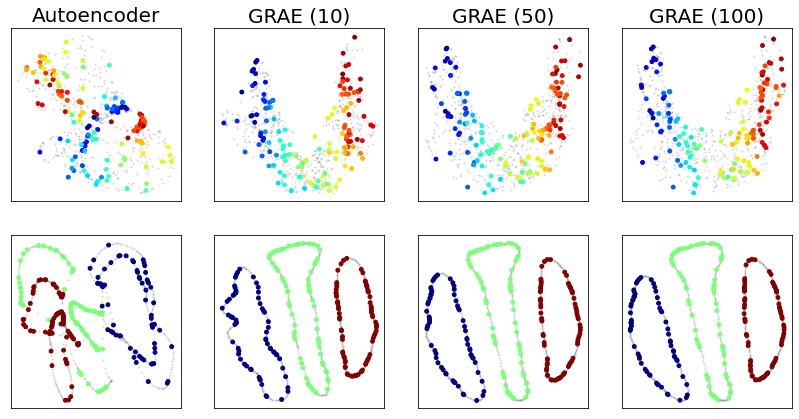

In [58]:
# Plot embeddings
PLOT_RUN = 1


titles = [model_name[m] for m in MODELS]
n_d = len(DATASETS)
n_m = len(MODELS)
fig, ax = plt.subplots(n_d, n_m, figsize=(n_m * 3.5, n_d * 3.5))

for j, model in enumerate(MODELS):
  for i, dataset in enumerate(DATASETS):
    file_path = os.path.join('embeddings', model, dataset, f'run_{PLOT_RUN}.pkl')

    if os.path.exists(file_path):
      # Retrieve datasets for coloring
      data = load_dict(file_path)
      X_train = dataset_constructors[dataset](split='train',
                                              seed=data['dataset_seed'])
      X_test = dataset_constructors[dataset](split='test',
                                             seed=data['dataset_seed'])
      _, y_train = X_train.numpy()
      _, y_test = X_test.numpy()
      z_train, z_test = data['z_train'], data['z_test']
    else:
      # Filler if plot is not found
      z_train, z_test = np.array([[0, 0]]), np.array([[0, 0]])
      y_train = np.array([1])
      y_test = np.array([1])


    if n_d == 1:
      ax_i = ax[j]
    elif n_m == 1:
      ax_i = ax[i]
    else:
      ax_i = ax[i, j]

    l = ax_i.scatter(*z_train.T, s = 1.5,  alpha=.2, color='grey')

    ax_i.scatter(*z_test.T, c = y_test, s = 15, cmap='jet')



    if i == 0:
      ax_i.set_title(f'{titles[j]}', fontsize=20, color='black')
    ax_i.set_xticks([])
    ax_i.set_yticks([])


plt.savefig(os.path.join('results', 'plot.png'))
plt.show()

## Score embeddings

In [59]:
# Two groups of metrics
UNSUPERVISED = True
SUPERVISED = True

rootdir = 'embeddings'

# Datasets on which supervised metrics can be computed
DATASETS_SUP = ['ribbons', 'Faces']


# Define required metrics
# Supervised metrics
SUP_METRICS = ['dist_corr',
               'pearson_source_1', 'pearson_source_2',
               'pearson_ICA_source_1','pearson_ICA_source_2',
               'pearson_slice_source_1', 'pearson_slice_source_2',
               'spearman_source_1', 'spearman_source_2',
               'spearman_ICA_source_1', 'spearman_ICA_source_2',
               'spearman_slice_source_1', 'spearman_slice_source_2',
               'mutual_information_source_1', 'mutual_information_source_2',
               'mutual_information_ICA_source_1', 'mutual_information_ICA_source_2',
               'mutual_information_slice_source_1', 'mutual_information_slice_source_2'
]


# Usupervised Metrics
metrics_uns = list()

for m in ('continuity', 'trustworthiness', 'mrre'):
  for k in (5, 10):
    metrics_uns.append(f'{m}_{k}')


# File to save data
unsupervised_name = os.path.join('results', 'unsupervised_raw.csv')
supervised_name = os.path.join('results', 'supervised_raw.csv')


# Loogers for results
book_uns = Book(models=MODELS,
                datasets=DATASETS,
                metrics=metrics_uns + ['reconstruction'])

book_sup = Book(models=MODELS,
                datasets=DATASETS,
                metrics=SUP_METRICS)

# Iterate over all embeddings
for subdir, dirs, files in os.walk(rootdir):

    for file in files:
        _, model, dataset = os.path.normpath(subdir).split(os.sep)

        if dataset not in DATASETS:
            continue
        if model not in MODELS:
            continue

        filepath = subdir + os.sep + file
        print(f'Scoring {filepath}...')
        data = load_dict(filepath)

        dataset_seed = data['dataset_seed']
        run_seed = data['run_seed']


        # Only compute on test split for the paper
        X_test = dataset_constructors[dataset](split='test', seed=dataset_seed)
        x_test, y_test = X_test.numpy()
        z_test = data['z_test']


        if UNSUPERVISED:
            scorer_test = MeasureCalculator(x_test, z_test, None)
            test_metrics = scorer_test.get_metrics(metrics_uns)
            test_metrics.update(dict(reconstruction=data['rec_test']))

            book_uns.add_entry(model=model, dataset=dataset, run=run_seed,
                               split='test', **test_metrics)

        if SUPERVISED and dataset in DATASETS_SUP:
            y_1_test, y_2_test = X_test.get_source()

            metrics_sup = supervised_metrics(y_1_test, y_2_test,
                                             *z_test.T)

            book_sup.add_entry(model=model, dataset=dataset,
                               run=run_seed, split='test', **metrics_sup)

if UNSUPERVISED:
    df = book_uns.get_df()
    df.to_csv(unsupervised_name)

if SUPERVISED:
    df = book_sup.get_df()
    df.to_csv(supervised_name)


Scoring embeddings\AE\Faces\run_1.pkl...
Scoring embeddings\AE\RotatedDigits\run_1.pkl...
Scoring embeddings\GRAE_10\Faces\run_1.pkl...
Scoring embeddings\GRAE_10\RotatedDigits\run_1.pkl...
Scoring embeddings\GRAE_100\Faces\run_1.pkl...
Scoring embeddings\GRAE_100\RotatedDigits\run_1.pkl...
Scoring embeddings\GRAE_50\Faces\run_1.pkl...
Scoring embeddings\GRAE_50\RotatedDigits\run_1.pkl...


In [60]:
# Define beter names for dataframe columns in next cell
col_map = dict(dataset='Dataset', model='Model',
               continuity='Cont', trustworthiness='Trust', mrre='MRRE',
               reconstruction='Reconstruction',
               corr_source='Correlation',
               corr_source_ICA='Correlation ICA',
               pearson='Pearson',
               spearman='Spearman',
               mutual_information='MI',
               pearson_ICA='Pearson ICA',
               spearman_ICA='Spearman ICA',
               mutual_information_ICA='MI ICA',
               pearson_slice='Pearson Section',
               spearman_slice='Spearman Section',
               mutual_information_slice='MI Section',
               dist_corr='Distance Corr.',
               corr_source_patch='Patch Correlation',
               corr_source_ICA_patch='Patch Correlation ICA',
)

for i in (5, 10, 20):
    for s in ('continuity', 'trustworthiness', 'mrre'):
        base = col_map[s]
        col_map[f'{s}_{i}'] = f'{base} ({i})'

In [61]:
# Show metrics function
def show_metrics(supervised):
  file =os.path.join('results', 'supervised_raw.csv') \
      if supervised else os.path.join('results', 'unsupervised_raw.csv')

  df = pd.read_csv(file, index_col=0)

  # Keep only test data from MODELS and DATASETS
  df = df[df['model'].isin(MODELS)]
  df = df[df['dataset'].isin(DATASETS)]
  df = df[df['split'] == 'test']

  df = df.drop(columns=['split', 'run'])

  metrics_datasets = copy.deepcopy(DATASETS)

  if supervised:
    # Do not include Rotated Digits, as they don't have a clear ground truth
    metrics_datasets.remove('RotatedDigits')
    # Average pearson, spearman and MI over source 1 and source 2
    df = df[df.dataset != 'RotatedDigits']
    for base in ('pearson', 'spearman', 'mutual_information'):
        df[f'{base}'] = (df[f'{base}_source_1'] + df[f'{base}_source_2'])/2
        df[f'{base}_ICA'] = (df[f'{base}_ICA_source_1'] + df[f'{base}_ICA_source_2'])/2
        df[f'{base}_slice'] = (df[f'{base}_slice_source_1'] + df[f'{base}_slice_source_2'])/2

    # Keep only relevant columns
    df = df[['dataset', 'model', 'dist_corr',
                 'pearson', 'pearson_ICA', 'pearson_slice',
                 'spearman', 'spearman_ICA', 'spearman_slice',
                 'mutual_information', 'mutual_information_ICA', 'mutual_information_slice',
                 ]]


  # Provide order for models and datasets if needed
  df['model'] = pd.Categorical(df['model'], MODELS)
  df['dataset'] = pd.Categorical(df['dataset'], metrics_datasets)

  # Prettify names
  df['model'] = df['model'].map(model_name)
  df['dataset'] = df['dataset'].map(ds_name)

  # Prettify column names
  df = df.rename(columns=col_map)

  # Mean
  return df.groupby(['Dataset', 'Model']).mean().round(3)


In [62]:
# View unsupervised metrics
show_metrics(supervised=False)

Cont (5)  Cont (10)  Trust (5)  Trust (10)  \
Dataset        Model                                                     
Faces          Autoencoder     0.931      0.936      0.944       0.948   
               GRAE (10)       0.934      0.934      0.954       0.951   
               GRAE (50)       0.938      0.926      0.918       0.903   
               GRAE (100)      0.935      0.919      0.899       0.873   
Rotated Digits Autoencoder     0.957      0.908      0.969       0.941   
               GRAE (10)       0.952      0.819      0.990       0.926   
               GRAE (50)       0.952      0.818      0.989       0.925   
               GRAE (100)      0.952      0.818      0.987       0.925   

                            MRRE (5)  MRRE (10)  Reconstruction  
Dataset        Model                                             
Faces          Autoencoder     0.067      0.071           0.019  
               GRAE (10)       0.054      0.059           0.016  
               GRAE (50)       0.087      0.098           0.019  
               GRAE (100)      0.097      0.115           0.021  
Rotated Digits Autoencoder     0.028      0.043           0.019  
               GRAE (10)       0.006      0.033           0.016  
               GRAE (50)       0.006      0.033           0.015  
               GRAE (100)      0.007      0.034           0.017

In [63]:
# View supervised metrics
show_metrics(supervised=True)



Distance Corr.  Pearson  Pearson ICA  Pearson Section  \
Dataset Model                                                                
Faces   Autoencoder           0.015    0.283        0.307            0.392   
        GRAE (10)             0.757    0.616        0.622            0.729   
        GRAE (50)             0.727    0.734        0.740            0.832   
        GRAE (100)            0.725    0.764        0.768            0.860   

                     Spearman  Spearman ICA  Spearman Section     MI  MI ICA  \
Dataset Model                                                                  
Faces   Autoencoder     0.268         0.304             0.397  0.323   0.325   
        GRAE (10)       0.612         0.624             0.726  0.875   0.821   
        GRAE (50)       0.731         0.739             0.812  0.908   0.932   
        GRAE (100)      0.768         0.774             0.849  0.890   0.894   

                     MI Section  
Dataset Model                    
Faces   Autoencoder       0.178  
        GRAE (10)         0.589  
        GRAE (50)         0.683  
        GRAE (100)        0.671